## Modelowanie i wymiarowanie systemów wielousługowych

In [1]:
import numpy as np
import math
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns

### Funkcja1: wyznaczanie rozkładu zajętości p[n] wg algorytmu Kaufmana-Robertsa (wzór nr 4)

Oblicza rozkład zajętości w systemie pełnodostępnym z ruchem wielousługowym.

Parametry:
- C      - pojemność systemu (liczba AUs),
- a_list - lista średnich natężeń ruchu [a1, a2, ..., am],
- t_list - lista żądań zasobowych [t1, t2, ..., tm].

Zwraca:

- p - lista prawdopodobieństw p[n] dla n=0..C,
- s - lista wartości pomocniczych s[n] (przed normalizacją).

In [2]:
def kaufman_roberts(
    C: int,
    a_list: List[float],
    t_list: List[int]) -> Tuple[List[float], List[float]]:

    m = len(a_list)
    if len(t_list) != m:
        raise ValueError("ERROR: Długości a_list i t_list muszą być takie same (m klas).")

    # s[0] = 1
    s = [0.0] * (C + 1)
    s[0] = 1.0

    # s[n] = (1/n) * Σ_i ( a_i * t_i * s[n - t_i] )
    for n in range(1, C + 1):
        acc = 0.0
        for i in range(m):
            ti = t_list[i]
            if n - ti >= 0:
                acc += a_list[i] * ti * s[n - ti]
        s[n] = acc / n

    # normalizacja
    norm = sum(s)
    if norm == 0:
        raise ZeroDivisionError("ERROR: Suma s[n] wyszła 0 - coś jest nie tak z parametrami.")

    p = [sn / norm for sn in s]
    return p, s

### Funkcja2: prawdopodobieństwo blokady dla każdej klasy (wzór 5)

Oblicza prawdopodobieństwa blokady E_i dla każdej klasy i.

Parametry:
- p      – rozkład zajętości p[n] dla n=0..C,
- t_list – lista żądań zasobowych [t1, t2, ..., tm].

Zwraca:
- E_list – lista prawdopodobieństw blokady [E1, E2, ..., Em].

In [3]:
def blocking_probabilities(
    p: List[float],
    t_list: List[int]) -> List[float]:

    C = len(p) - 1
    E_list = []

    for ti in t_list:
        # Ei = suma p[n] dla n = C - ti + 1 .. C
        start = max(0, C - ti + 1)
        Ei = sum(p[n] for n in range(start, C + 1))
        E_list.append(Ei)

    return E_list

### Funkcja3: średnia liczb zajętych zasobów przez klasę i w stanie n (wzór 6)

Oblicza y_i(n) – średnią liczbę zajętych AUs przez klasę i w stanie n.

Wzór:

y_i(n) = **(a_i * t_i * p[n - t_i]) / p[n]** jeśli n - t_i >= 0 i p[n] > 0

**0** w p.p.

Parametry:
- p      – lista p[n], n=0..C
- a_list – lista a_i
- t_list – lista t_i

Zwraca:
- słownik: n -> lista [y_1(n), y_2(n), ..., y_m(n)]

In [4]:
def mean_occupied_per_state(
    p: List[float],
    a_list: List[float],
    t_list: List[int]) -> Dict[int, List[float]]:

    C = len(p) - 1
    m = len(a_list)

    result: Dict[int, List[float]] = {}

    for n in range(C + 1):
        y_n = []
        for i in range(m):
            ti = t_list[i]
            ai = a_list[i]

            if n - ti < 0 or p[n] == 0:
                y_i_n = 0.0
            else:
                y_i_n = (ai * ti * p[n - ti]) / p[n]
            y_n.append(y_i_n)

        result[n] = y_n

    return result

### Funkcja4: wyznaczanie a_i (wzór 7)

Wyznacza a_i ze wzoru:
**a_i = a * C / (m * t_i)**

Parametry:
- a_total – ruch oferowany na jednostkę pojemności (a),
- C       – pojemność systemu,
- t_list  – lista t_i.

Zwraca:
- a_list – lista a_i (dla każdej klasy).

In [5]:
def compute_ai_for_total_a(
    a_total: float,
    C: int,
    t_list: List[int]) -> List[float]:
    
    m = len(t_list)
    a_list = []
    for ti in t_list:
        ai = a_total * C / (m * ti)
        a_list.append(ai)
    return a_list

### Funkcja5: Przykładowe użycie - jedno wywołanie dla zadanych parametrów

Przykład: C = 20, dwa strumienie t1=1, t2=3, a = 0.8 Erl / AU

In [6]:
def example_single_run():
    C = 20
    t_list = [1, 3]   # t1, t2
    a_total = 0.8     # np. jeden punkt z zakresu amin..amax

    a_list = compute_ai_for_total_a(a_total, C, t_list)
    p, s = kaufman_roberts(C, a_list, t_list)
    E_list = blocking_probabilities(p, t_list)
    y = mean_occupied_per_state(p, a_list, t_list)

    print("a_total =", a_total)
    print("a_list  =", a_list)
    print("E_list  =", E_list)
    print("Przykładowe y_i(n) dla n=10:", y[10])

### Funkcja6: Przykład pętli po a (amin..amax z astep)

In [7]:
def sweep_over_a(
    amin: float,
    amax: float,
    astep: float,
    C: int,
    t_list: List[int]):
    
    a_values = []
    E_values_per_class = []

    a = amin
    while a <= amax + 1e-9:
        a_list = compute_ai_for_total_a(a, C, t_list)
        p, s = kaufman_roberts(C, a_list, t_list)
        E_list = blocking_probabilities(p, t_list)

        a_values.append(a)
        E_values_per_class.append(E_list)

        print(f"a={a:.3f}, E={E_list}")
        a += astep

    return a_values, E_values_per_class

a_total = 0.8
a_list  = [8.0, 2.6666666666666665]
E_list  = [0.060922492153821374, 0.206913223030226]
Przykładowe y_i(n) dla n=10: [6.467772814294832, 3.5322271857051692]

--- Sweep over a --- t_params: [1, 2] ---
a=0.200, E=[0.0005840681750748047, 0.002195545237728541]
a=0.300, E=[0.003866602778964813, 0.012298144530672437]
a=0.400, E=[0.01279671331574769, 0.03627239435943531]
a=0.500, E=[0.0289692252746071, 0.0752936540629252]
a=0.600, E=[0.051932237229936444, 0.12599666952095318]
a=0.700, E=[0.0799373980746912, 0.1832575944382162]
a=0.800, E=[0.1109439663533622, 0.24245387228993992]
a=0.900, E=[0.14321315131089257, 0.30033521477974623]
a=1.000, E=[0.17548860001308875, 0.35499175266101657]
a=1.100, E=[0.20695843043780407, 0.40550491372112574]
a=1.200, E=[0.23714817884589642, 0.4515896934211805]
a=1.300, E=[0.2658150780434127, 0.49332583754803383]


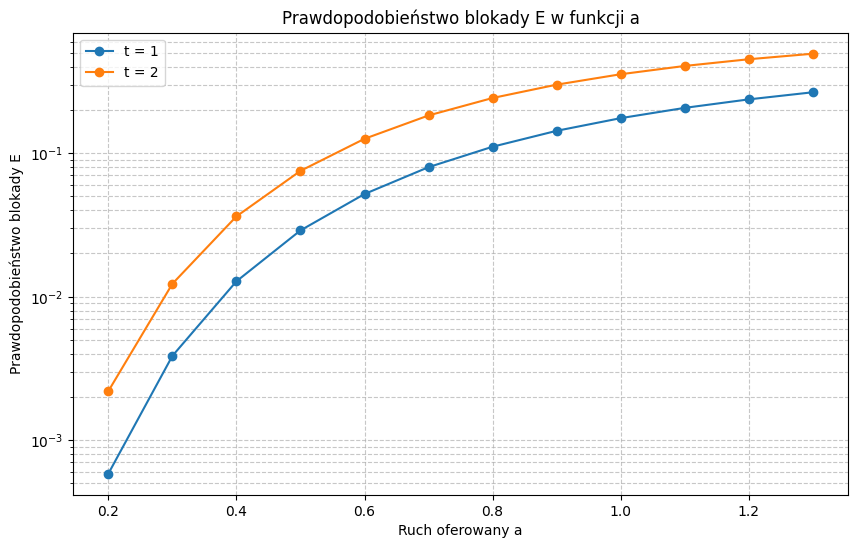

In [8]:
if __name__ == "__main__":
    
    example_single_run()
    
    t_params = [1, 2]
    
    print(f"\n--- Sweep over a --- t_params: {t_params} ---")
    a_values, E_matrix = sweep_over_a(
        amin=0.2,
        amax=1.3,
        astep=0.1,
        C=10,
        t_list=t_params
    )

    plt.figure(figsize=(10, 6))
    
    for i, t_val in enumerate(t_params):
        y_values = [row[i] for row in E_matrix]
        plt.plot(
            a_values, 
            y_values, 
            marker='o',     
            linestyle='-',  
            label=f't = {t_val}'
        )

    plt.title('Prawdopodobieństwo blokady E w funkcji a')
    plt.xlabel('Ruch oferowany a')
    plt.ylabel('Prawdopodobieństwo blokady E')
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()


--- Sweep over a --- t_params: [1, 3] ---
a=0.200, E=[0.0022586934156041726, 0.014531211423265002]
a=0.300, E=[0.008100463478922581, 0.04524706864167398]
a=0.400, E=[0.018848262425807626, 0.09270082914231347]
a=0.500, E=[0.03446522224910537, 0.15170288836849471]
a=0.600, E=[0.05407312036316896, 0.21645706183295568]
a=0.700, E=[0.07647512025690795, 0.2822801566026217]
a=0.800, E=[0.1005376059645367, 0.3460212681965985]
a=0.900, E=[0.1253561332182008, 0.40585901004408764]
a=1.000, E=[0.15027851050940352, 0.4609277231893283]
a=1.100, E=[0.17486594158127056, 0.5109754971230545]
a=1.200, E=[0.1988399140423852, 0.5561109617712364]
a=1.300, E=[0.2220348243420189, 0.5966347795705926]


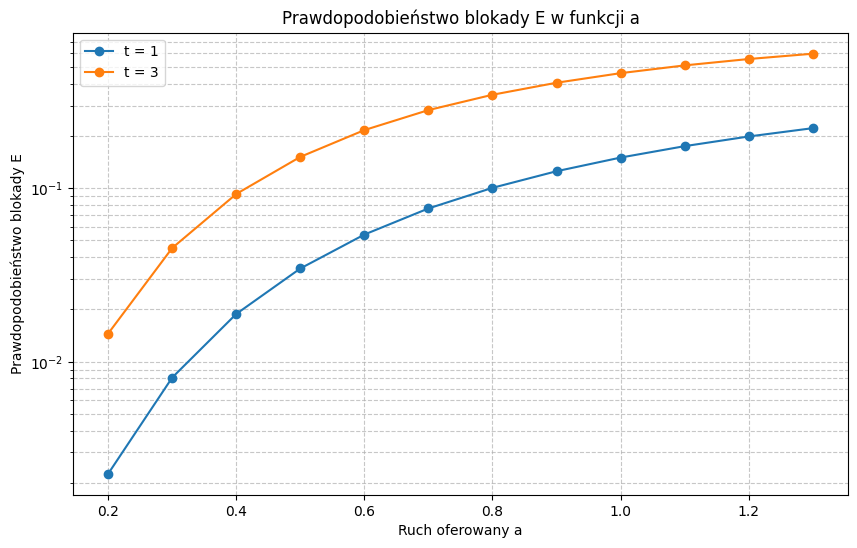

In [9]:
if __name__ == "__main__":

    t_params = [1, 3]
    
    print(f"\n--- Sweep over a --- t_params: {t_params} ---")
    a_values, E_matrix = sweep_over_a(
        amin=0.2,
        amax=1.3,
        astep=0.1,
        C=10,
        t_list=t_params
    )

    plt.figure(figsize=(10, 6))
    
    for i, t_val in enumerate(t_params):
        y_values = [row[i] for row in E_matrix]
        plt.plot(
            a_values, 
            y_values, 
            marker='o',      
            linestyle='-',   
            label=f't = {t_val}'
        )

    plt.title('Prawdopodobieństwo blokady E w funkcji a')
    plt.xlabel('Ruch oferowany a')
    plt.ylabel('Prawdopodobieństwo blokady E')
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()


--- Sweep over a --- t_params: [1, 3, 4] ---
a=0.200, E=[0.0036649785820620498, 0.02690565576717875, 0.049144773970830676]
a=0.300, E=[0.010940156219765953, 0.062494650274502565, 0.10320703398768155]
a=0.400, E=[0.022368092079058342, 0.10788820768975368, 0.1676080375589519]
a=0.500, E=[0.037152983464220454, 0.1584151321522592, 0.2359660546229564]
a=0.600, E=[0.054246221737903964, 0.21053546794032071, 0.30374097216586876]
a=0.700, E=[0.07269098956172969, 0.26192791966639223, 0.36816023026877687]
a=0.800, E=[0.09174873494620239, 0.3112237974584175, 0.42778789106420967]
a=0.900, E=[0.11090464717472291, 0.35770534167563595, 0.4820728347091946]
a=1.000, E=[0.12982613134668344, 0.4010674166855891, 0.5309958259959033]
a=1.100, E=[0.1483130284771304, 0.4412531484741523, 0.574828599460635]
a=1.200, E=[0.16625492299850206, 0.4783479323080373, 0.6139821631339277]
a=1.300, E=[0.18359922032247775, 0.5125136091646212, 0.648916859704175]


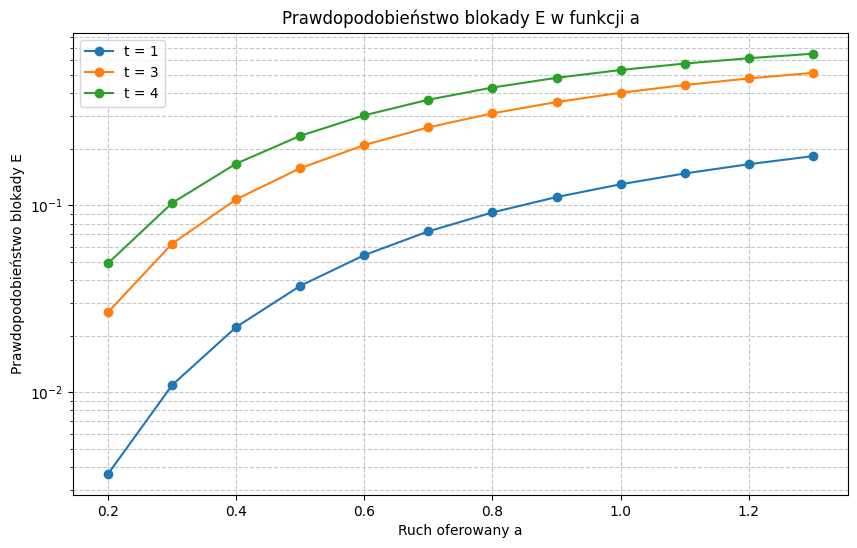

In [10]:
if __name__ == "__main__":
    
    t_params = [1, 3, 4]
    
    print(f"\n--- Sweep over a --- t_params: {t_params} ---")
    a_values, E_matrix = sweep_over_a(
        amin=0.2,
        amax=1.3,
        astep=0.1,
        C=10,
        t_list=t_params
    )

    plt.figure(figsize=(10, 6))
    
    for i, t_val in enumerate(t_params):
        y_values = [row[i] for row in E_matrix]
        plt.plot(
            a_values, 
            y_values, 
            marker='o',    
            linestyle='-',   
            label=f't = {t_val}'
        )

    plt.title('Prawdopodobieństwo blokady E w funkcji a')
    plt.xlabel('Ruch oferowany a')
    plt.ylabel('Prawdopodobieństwo blokady E')
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()